In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import json

In [25]:
df = pd.read_csv("results/person_level_results2.csv")
# json dosyasını oku
with open("jsons/340k.json", "r", encoding="utf-8") as f:
    creators = json.load(f)

# creator_id -> unique_username mapping
id_to_username = {
    item["creator_id"]: item["unique_username"]
    for item in creators
}
df["username"] = df["creator_id"].map(id_to_username)

cols = ["username","creator_id","predicted_country","confidence_score","raw_prediction","inference_time_sec","input_tokens","output_tokens"]
df = df[cols]

# Bazı tahminler

In [26]:
df.tail()

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
329995,kamelyapirates,1294159,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.071,338.0,13.0
329996,estefaniemarie888,1294160,Mexican,0.80,nationality: Mexican\nconfidence: 0.8,0.071,339.0,12.0
329997,lvm.rhl21,1294161,NaN,0.00,nationality: null\nconfidence: 0,0.071,271.0,10.0
329998,tiktokwithmichael,1294162,United States,0.95,nationality: United States\nconfidence: 0.95,0.071,342.0,14.0
329999,jihr_16,1294163,NaN,0.00,nationality: null\nconfidence: 0.0,0.071,300.0,12.0


# her column için null ne non null sayıları

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   username            329999 non-null  object 
 1   creator_id          330000 non-null  int64  
 2   predicted_country   93182 non-null   object 
 3   confidence_score    273224 non-null  float64
 4   raw_prediction      330000 non-null  object 
 5   inference_time_sec  330000 non-null  float64
 6   input_tokens        307600 non-null  float64
 7   output_tokens       307600 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 20.1+ MB


### 1 kişi için username ve creator_id eşleşmemiş o kişi kim?

In [29]:
df[df["username"].isna()]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
11001,NaN,58429,NaN,0.0,nationality: null\nconfidence: 0.0,0.0743,399.0,12.0


# Toplam kaç farklı ülke tahmin edildi?

In [30]:
df["predicted_country"].nunique()

569

## Bu tahminler neler?

In [31]:
df["predicted_country"].unique()

array([nan, 'South African', 'Philippines', 'South Africa', 'Brazil',
       'South Korea', 'United States', 'Thai', 'Netherlands', 'Denmark',
       'Canada', 'Israeli', 'American', 'Wales', 'Bolivia', 'Persian',
       'Venezuelan', 'Indian', 'Kenya', 'Colombia', 'Italian', 'Ireland',
       'Australia', 'Irish', 'Danish', 'United Kingdom', 'Japanese',
       'Saudi Arabia', 'Indonesia', 'Myanmar', 'Chinese', 'Algeria',
       'United Arab Emirates', 'Russian', 'Puerto Rico', 'Peru', 'French',
       'Ukraine', 'Venezuela', 'Mexican', 'Angola', 'Spanish', 'Cambodia',
       'Nigeria', 'Filipino', 'Haiti', 'Democratic Republic of the Congo',
       'Portugal', 'Tanzania', 'Ghana', 'Uganda', 'British', 'Turkish',
       'Dominican Republic', 'Guinea', 'Nigerian', 'Madagascar',
       'Singapore', 'Uruguay', 'France', 'Mexico', 'Indonesian', 'German',
       'Scotland', 'Scottish', 'Israel', 'Sweden', 'Australian',
       'Finnish', 'Belgium', 'California', 'Greek', 'Cebuana', 'Korean',

### Bazı düzeltilecek tahminler var örneğin
- South African ve South Africa gibi aynı anlama gelen tahminler
- "texas-based" gibi tahminler
- "American Korean" gibi anlamsız tahminler
- "New York" gibi şehir isimleri
### Bu ve bunun gibi durumlar filtrelemeyle düzeltilir tekrardan tahmin ettirmeye gerek yok

American Korean olarak işaretlenen kişi kim?

In [32]:
df[df["predicted_country"] == "American Korean"]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
309974,mayanakoa,1262145,American Korean,0.95,nationality: American Korean\nconfidence: 0.95,0.0559,269.0,14.0


![Koreli](pics/american%20korean.png)

## Hangi ülkeden kaç tahmin yapıldı

In [33]:
df["predicted_country"].value_counts()

predicted_country
Netherlands           20616
United States         11951
Spanish                3935
Mexican                3885
Brazil                 2908
                      ...  
Ireland/Lithuania         1
Circassian                1
Western Australia         1
Chamorro                  1
Cuban/Puerto Rican        1
Name: count, Length: 569, dtype: int64

### 330000 kişi arasında 1000'den fazla tahmin edilen ülkeler

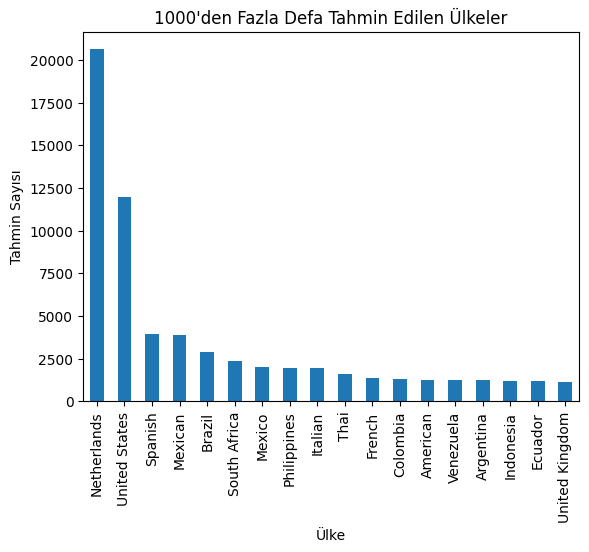

In [38]:
vc = df["predicted_country"].value_counts()
vc_filtered = vc[vc > 1000]

vc_filtered.plot(kind="bar")

# eksen etiketleri
plt.xlabel("Ülke")
plt.ylabel("Tahmin Sayısı")
plt.title("1000'den Fazla Defa Tahmin Edilen Ülkeler")

plt.show()


### TODO burada predictec_country columnu düzenlenince bu sonuçlar değişecek örneğin
- Ireland/Lithuania olarak tahmin yapılmış bu Ireland olarak düzenlenecek Ireland tahmin sayısı +1 olacak
- Western Australia tahmini Australia olarak düzenlenecek
- Chamorro, Circassian gibi tahminler null veya uygun şekilde güncellenecek

### Confidence değeri %70'den büyük olan tahminler

In [36]:
df_confidence = df[df["confidence_score"] > 0.7]
df_confidence.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93053 entries, 4 to 329998
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   username            93053 non-null  object 
 1   creator_id          93053 non-null  int64  
 2   predicted_country   93053 non-null  object 
 3   confidence_score    93053 non-null  float64
 4   raw_prediction      93053 non-null  object 
 5   inference_time_sec  93053 non-null  float64
 6   input_tokens        93053 non-null  float64
 7   output_tokens       93053 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.4+ MB


#### 93053 kişi için confidence değeri % 70'ten büyük.Toplamda 93182 kişi tahmin edilmişti. 
#### Bazı tahminler

In [37]:
df_confidence.head()

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
4,melissalimes,714,South African,0.80,nationality: South African\nconfidence: 0.8,0.047,380.0,13.0
5,jufelgomez17,715,Philippines,0.90,nationality: Philippines\nconfidence: 0.9,0.047,385.0,12.0
9,sherlynnmercado,719,Philippines,0.95,nationality: Philippines\nconfidence: 0.95,0.047,368.0,13.0
10,unkabogableviceganda,720,Philippines,0.90,nationality: Philippines\nconfidence: 0.9,0.047,397.0,12.0
11,dreamboysza,721,South Africa,0.90,nationality: South Africa\nconfidence: 0.9,0.047,349.0,13.0


#### Buradaki `melissalimes`adlı kullanıcı sürekli koreli makyaj malzemeleri ve `korede yaşam`, `kore 2040 yılında yaşıyor` gibi postlar at bio'da kore bayrağı vardı. Bunu South African diye (sanırım) doğru tahmin etti

![melissalimes](pics/melissalimes.png)

### Bazı Türk tahminleri (doğrulaması kolay olsun)

In [39]:
df_confidence[df_confidence["predicted_country"].isin(["Turkey", "TR", "Turkiye"])]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
2403,teef20q,47379,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.0639,380.0,13.0
3613,ecececo04,48919,Turkey,0.90,nationality: Turkey\nconfidence: 0.9,0.0608,417.0,12.0
6620,karyagdiiii,52695,Turkey,0.90,nationality: Turkey\nconfidence: 0.9,0.0958,407.0,12.0
13491,olga.sonze,62166,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.0503,359.0,13.0
14636,karaakrep111,69738,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.0749,555.0,13.0
...,...,...,...,...,...,...,...,...
309114,userkub_,1261143,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.0509,303.0,13.0
315277,kimhaanschoten,1274465,Turkey,0.95,nationality: Turkey\nconfidence: 0.95,0.0557,290.0,13.0
323771,alexandra_ffm10,1284998,Turkey,0.80,nationality: Turkey\nconfidence: 0.8,0.0437,328.0,12.0
324772,sevvlklync11,1286012,Turkey,0.90,nationality: Turkey\nconfidence: 0.9,0.0396,318.0,12.0


## Benim tespit ettiğim 2 şüpheli kullanıcı var.
- `teef20q`
- `kimhaanschoten`
Bu kişiler için `teef20q` herşey arapça ancak iletişim için verilen telefon numarası tr.

`kimhaanschoten` ise flemenkçe yazmış ancak flemenkçe 'Ben türküm' yazmış profilde ayasofya ve türk bayrağı var

## Koreli olarak işaretlenen bazı kişiler

In [40]:
df_confidence[df_confidence["predicted_country"].isin(["South Korea","Korea","Korean"])]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
15,lovenunubear,725,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0470,412.0,14.0
270,jypestraykids,1017,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0626,377.0,14.0
271,enhypen,1018,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0626,303.0,14.0
272,istent_theboyz,1020,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0626,317.0,14.0
273,tik_tyong,1021,South Korea,0.90,nationality: South Korea\nconfidence: 0.9,0.0626,289.0,13.0
...,...,...,...,...,...,...,...,...
328532,rtuli886,1291013,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0642,388.0,14.0
328577,cegilnyaexo12,1291058,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0713,311.0,14.0
328697,snellia.bts3,1291178,South Korea,0.95,nationality: South Korea\nconfidence: 0.95,0.0713,289.0,14.0
328949,ershat090qqq,1291636,Korean,0.90,nationality: Korean\nconfidence: 0.9,0.0486,519.0,12.0


- Burada `cegilnyaexo12`kişisi sanırım kore fanı olan bir endonezyalı ancak yüksek confidence ile koreli işaretlenmiş
![cegilnyaexo12](pics/cegilnyaexo12.png)

## Hollandalı olarak işaretlenenler

In [41]:
df_confidence[df_confidence["predicted_country"] == "Netherlands"]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
21,.loisaandalio,731,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0470,307.0,13.0
50,larsson.mvita7,760,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0470,289.0,13.0
117,debrawhiteside,829,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0470,318.0,13.0
122,mengdiidara,834,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0470,284.0,13.0
149,craftycozyvibes6,861,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0951,303.0,13.0
...,...,...,...,...,...,...,...,...
329888,aubazzi,1294052,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0430,296.0,13.0
329936,sarafreysdot3,1294100,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0430,306.0,13.0
329975,sneakerbanque,1294139,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0430,345.0,13.0
329986,thealanaclark,1294150,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0710,284.0,13.0


## Amerika olarak işaretlenenler burada yanlış olma ihtimali çok yüksek çünkü kullanılan dilin ingilizce olması nationality'nin US olacağı anlamına gelmez

In [42]:
df_confidence[df_confidence["predicted_country"] == "United States"]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
16,javirod305,726,United States,0.95,nationality: United States\nconfidence: 0.95,0.047,348.0,14.0
17,thesierracapri,727,United States,0.95,nationality: United States\nconfidence: 0.95,0.047,361.0,14.0
61,milane84,772,United States,0.95,nationality: United States\nconfidence: 0.95,0.047,296.0,14.0
70,tylahpaints,781,United States,0.90,nationality: United States\nconfidence: 0.9,0.047,344.0,13.0
94,averymyers7,806,United States,0.80,nationality: United States\nconfidence: 0.8,0.047,340.0,13.0
...,...,...,...,...,...,...,...,...
329943,miatrotman,1294107,United States,0.80,nationality: United States\nconfidence: 0.8,0.043,299.0,13.0
329946,j444ckalope,1294110,United States,0.95,nationality: United States\nconfidence: 0.95,0.043,294.0,14.0
329951,therysnproject,1294115,United States,0.80,nationality: United States\nconfidence: 0.8,0.043,319.0,13.0
329962,cami.canavati,1294126,United States,0.95,nationality: United States\nconfidence: 0.95,0.043,320.0,14.0


### Modelin tahmin yapamadığı hesaplar

In [44]:
df[df["predicted_country"].isna()]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
0,user4260512796791,138,NaN,NaN,"I'm sorry, but I cannot proceed without the ac...",0.047,269.0,32.0
1,flyiiingtwins,711,NaN,0.0,nationality: null\nconfidence: 0,0.047,301.0,10.0
2,dodooarts,712,NaN,0.0,nationality: null\nconfidence: 0.0,0.047,374.0,12.0
3,xebu.dance,713,NaN,0.0,nationality: null\nconfidence: 0.0,0.047,344.0,12.0
6,chillestcat,716,NaN,0.0,nationality: null\nconfidence: 0.0,0.047,358.0,12.0
...,...,...,...,...,...,...,...,...
329991,owen..wood,1294155,NaN,0.0,nationality: null\nconfidence: 0.0,0.071,288.0,12.0
329992,abbys.spam38,1294156,NaN,0.0,nationality: null\nconfidence: 0.0,0.071,298.0,12.0
329993,naes.aug,1294157,NaN,0.0,nationality: null\nconfidence: 0.0,0.071,302.0,12.0
329997,lvm.rhl21,1294161,NaN,0.0,nationality: null\nconfidence: 0,0.071,271.0,10.0


### Bu hesapların çoğu için yeterli input data yoktu. Yani ya profilinde yazı yok, biosunda yazı yok, post atmıyor veya atsada ne postunda yazı nede post açıklaması var veya tutarsız. Örneğin
- `user4260512796791` adlı kişi için modelin gördüğü değerler 
```python 
    "creator_id": 138,
    "profil_pic_ocr": "",
    "bio": "❤️",
    "post1_cover_ocr": "",
    "post1_description": ""
```
- `xebu.dance` adlı kullanıcı için modelin gördüğü değerler
```python

    "creator_id": 713,
    "profil_pic_ocr": "",
    "bio": "Break limits. Beyond potential.\nMandaue 1 Avenue, Alang-alang, Cebu",
    "post1_cover_ocr": "WATER",
    "post1_description": "how the water dance should be done🥵 dc: @Diff Fam cover by Sean from Crescendo and Angel from VIVID #water #tyla #watertyla #waterdancechallenge #fyp #trending #fypシ #dancecover #cebu "
```
Bunda açıklama var ama diller tutarsız genede `cebu`infosu vardı ama model güvenmemiş

# Inference istatistikleri

In [45]:
df_batch = pd.read_csv("results/batch_metrics2.csv")
df_batch.head()

,batch_index,batch_time_sec,batch_size,avg_input_tokens,avg_output_tokens,vram_allocated_mb,vram_reserved_mb
0,0,6.0141,128.0,318.44,14.49,15826.3,48704.0
1,1,12.1699,128.0,343.78,13.36,15829.0,72494.0
2,2,8.0157,128.0,319.78,14.13,15827.0,72498.0
3,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6.0175,128.0,318.03,14.67,15826.3,72496.0


### Her batch'te 128 kişi ve toplam 2580 batch var istatistikler


Batch Inference – Kişi Başı Ortalama Metrikler
--------------------------------------------
Ortalama süre (sn/kişi)        : 0.0571
Ortalama input token (kişi)    : 2.493
Ortalama output token (kişi)   : 0.1108



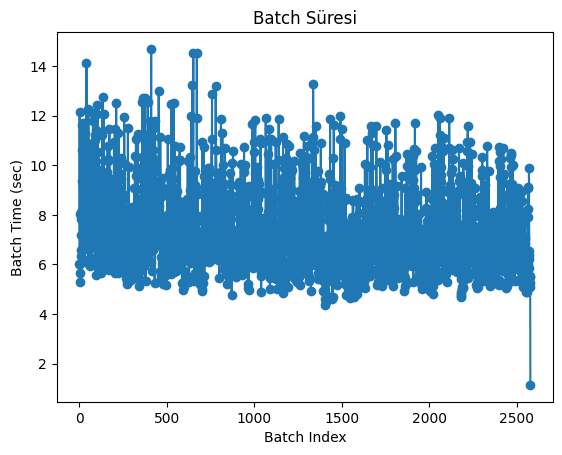

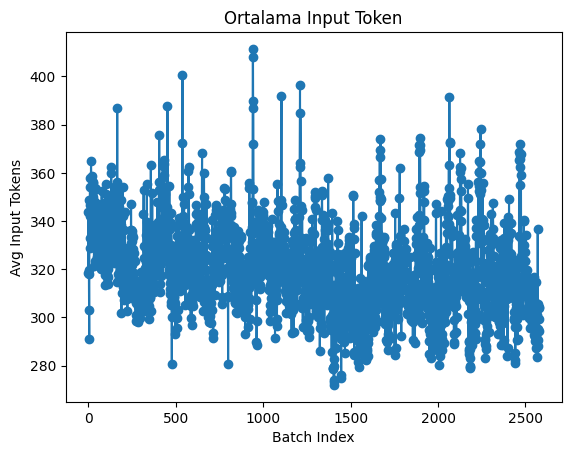

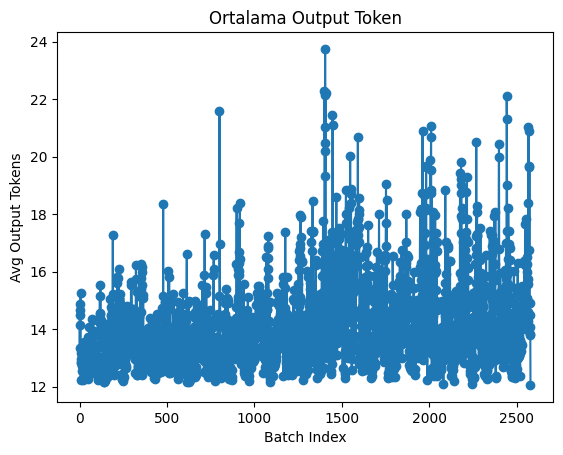

In [56]:
mean_time_per_person = round(float(df_batch["batch_time_sec"].mean() / 128),4)
avg_input_tokens_per_person = round(float(df_batch["avg_input_tokens"].mean() / 128),4)
avg_output_tokens_per_person = round(float(df_batch["avg_output_tokens"].mean() / 128),4)


# Print metrics
print(
    f"""
Batch Inference – Kişi Başı Ortalama Metrikler
--------------------------------------------
Ortalama süre (sn/kişi)        : {mean_time_per_person}
Ortalama input token (kişi)    : {avg_input_tokens_per_person}
Ortalama output token (kişi)   : {avg_output_tokens_per_person}
"""
)

# Prepare plot dataframe
df_plot = df_batch.dropna(subset=["batch_time_sec", "avg_input_tokens", "avg_output_tokens"])

# 1) Time per batch
plt.figure()
plt.plot(df_plot["batch_index"], df_plot["batch_time_sec"], marker="o")
plt.xlabel("Batch Index")
plt.ylabel("Batch Time (sec)")
plt.title("Batch Süresi")
plt.show()

# 2) Avg input tokens
plt.figure()
plt.plot(df_plot["batch_index"], df_plot["avg_input_tokens"], marker="o")
plt.xlabel("Batch Index")
plt.ylabel("Avg Input Tokens")
plt.title("Ortalama Input Token")
plt.show()

# 3) Avg output tokens
plt.figure()
plt.plot(df_plot["batch_index"], df_plot["avg_output_tokens"], marker="o")
plt.xlabel("Batch Index")
plt.ylabel("Avg Output Tokens")
plt.title("Ortalama Output Token")
plt.show()



## VRAM Kullanımı

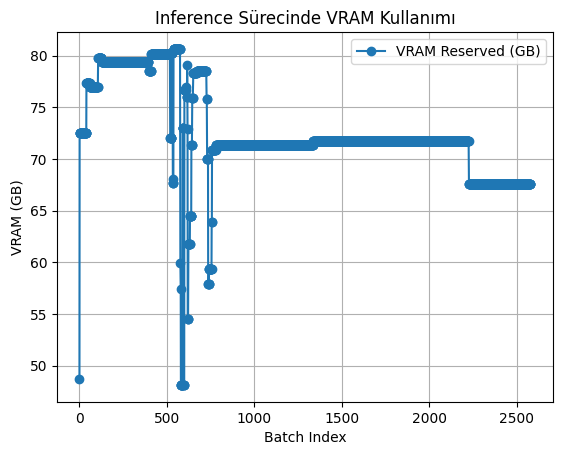

In [55]:
df_plot = df_batch.dropna(subset=["vram_allocated_mb", "vram_reserved_mb"])

# Line plot
plt.figure()
# plt.plot(df_plot["batch_index"], df_plot["vram_allocated_mb"]/1000, marker="o", label="VRAM Allocated (GB)")
plt.plot(df_plot["batch_index"], df_plot["vram_reserved_mb"]/1000, marker="o", label="VRAM Reserved (GB)")

plt.xlabel("Batch Index")
plt.ylabel("VRAM (GB)")
plt.title("Inference Sürecinde VRAM Kullanımı")
plt.legend()
plt.grid(True)
plt.show()

# Run metrics


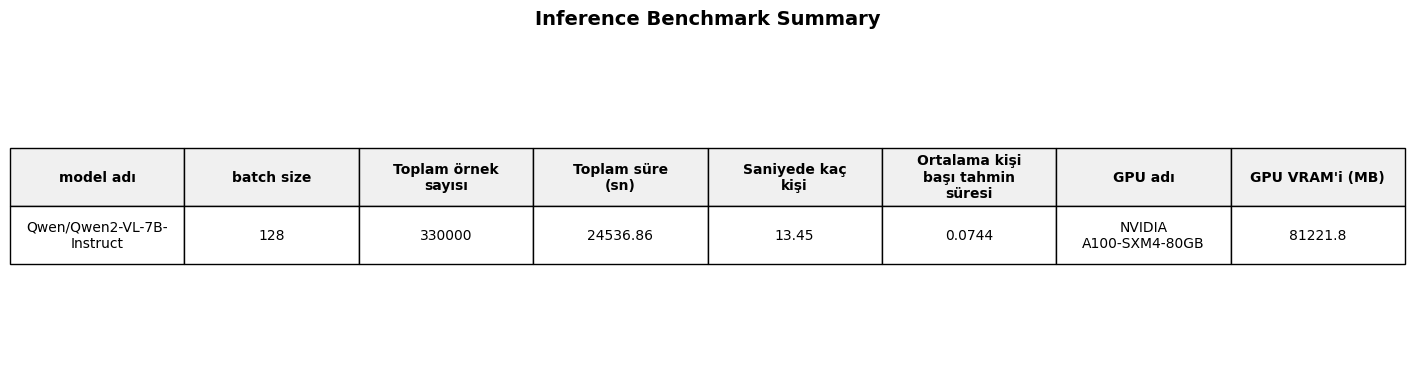

In [59]:
import matplotlib.pyplot as plt
import textwrap

# Data for the table
columns = [
    "model adı",
    "batch size",
    "Toplam örnek sayısı",
    "Toplam süre (sn)",
    "Saniyede kaç kişi",
    "Ortalama kişi başı tahmin süresi",
    "GPU adı",
    "GPU VRAM'i (MB)",
]

values = [[
    "Qwen/Qwen2-VL-7B-Instruct",
    128,
    330000,
    24536.86,
    13.45,
    0.0744,
    "NVIDIA A100-SXM4-80GB",
    81221.8
]]

# Function to wrap text to prevent overlapping
def wrap_text(text, width):
    return "\n".join(textwrap.wrap(str(text), width))

# Apply wrapping to columns and values
# We use different widths for headers vs content if needed, but here we pick a safe average
wrapped_columns = [wrap_text(col, 15) for col in columns]
wrapped_values = [[wrap_text(val, 20) for val in row] for row in values]

# Create figure - Make it WIDE to accommodate columns
fig, ax = plt.subplots(figsize=(18, 4)) 
ax.axis("off")

# Create table
table = ax.table(
    cellText=wrapped_values,
    colLabels=wrapped_columns,
    loc="center",
    cellLoc="center" # Center align text inside cells
)

# Improve readability
table.auto_set_font_size(False)
table.set_fontsize(10)

# Scale: (Width factor, Height factor)
# 1 means default width, 3 means 3x height to fit wrapped text (vertical expansion)
table.scale(1, 3.5) 

# Optional: Add some color to headers to distinguish them
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')

plt.title("Inference Benchmark Summary", pad=20, fontsize=14, weight='bold')

# Save the plot
plt.savefig("benchmark_table.png", bbox_inches='tight', dpi=300)

# Tamamen rasgele sonuçlar

In [60]:
import random
start_index = random.randint(0,len(df_confidence)-50)
end_index = start_index + 50
df_confidence[start_index:end_index]

,username,creator_id,predicted_country,confidence_score,raw_prediction,inference_time_sec,input_tokens,output_tokens
60384,yulymar_morales,254195,Venezuela,0.90,nationality: Venezuela\nconfidence: 0.9,0.0483,336.0,12.0
60385,randommbrunettee,254196,American,0.80,nationality: American\nconfidence: 0.8,0.0483,289.0,12.0
60388,londonfashions4,254199,British,0.95,nationality: British\nconfidence: 0.95,0.0483,358.0,13.0
60401,yanet.hernandez253,254212,Netherlands,0.95,nationality: Netherlands\nconfidence: 0.95,0.0483,284.0,13.0
60403,whatsairsees,254215,United States,0.95,nationality: United States\nconfidence: 0.95,0.0483,334.0,14.0
60406,juliean.j,254218,Japanese,0.95,nationality: Japanese\nconfidence: 0.95,0.0483,317.0,13.0
60407,beautyofjoseon.id,254219,Indonesia,0.95,nationality: Indonesia\nconfidence: 0.95,0.0483,426.0,13.0
60412,sb_duke6,254224,Malaysia,0.80,nationality: Malaysia\nconfidence: 0.8,0.0483,320.0,12.0
60413,lucydavistravel,254225,United Kingdom,0.95,nationality: United Kingdom\nconfidence: 0.95,0.0483,325.0,14.0
60414,yuslei7,254226,Venezuela,0.95,nationality: Venezuela\nconfidence: 0.95,0.0483,277.0,13.0
